In [1]:
import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd
import numpy as np
import shapely
from shapely import Polygon, to_geojson
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import shutil

api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable

load_dotenv()

params = {'limit': 1, 'pretty': True} # Limit API response to the most recent entry, return as pretty json
relevantFiles = [
    "MOD13A1.061__500m_16_days_EVI_",
    "MOD13A1.061__500m_16_days_NDVI_",
    "MOD15A2H.061_Lai_500m_",
    "DAYMET.004_prcp_",
    "DAYMET.004_tmax_",
    "DAYMET.004_tmin_",
]

fileOrder = ["prcp", "tmax", "tmin", "EVI", "NDVI", "Lai"]
originalRatio = [(7,6),(7,6),(7,6),(11,12),(11,12),(11,12)]

C:\Users\xubil\AppData\Local\Temp\ipykernel_32056\30379606.py:2: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import getpass, pprint, time, os, cgi, json


In [2]:
prods = ['MOD13A1.061', 'MOD15A2H.061', 'DAYMET.004']
layers = [(prods[0], '_500m_16_days_EVI'), (prods[0], '_500m_16_days_NDVI'), (prods[1], "Lai_500m"), (prods[2], 'prcp'), (prods[2], 'tmax'), (prods[2], 'tmin')]

task_type = ['point','area']        # Type of task, area or point
proj = 'geographic'  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
recurring = False                   # Specify True for a recurring date range
#yearRange = [2000,2016]            # if recurring = True, set yearRange, change start/end date to MM-DD

params = {'limit': 1, 'pretty': True} # Limit API response to the most recent entry, return as pretty json

bounds = np.load("../../data-training/ALL.npy", allow_pickle=True)
dates = np.load("../../data-training/ALL-dates.npy", allow_pickle=True)

prodLayer = []
for l in layers:
    prodLayer.append({
            "layer": l[1],
            "product": l[0]
          })

In [3]:
destDir = r"D:\Users\xubil\Wildfire Data\temp" # Temporary destination for the API files 
requestsDir = "../Requests"

In [4]:
user = os.getenv("EARTHDATA_USERNAME1")
password = os.getenv("EARTHDATA_PASSWORD1")
token_response = r.post('{}login'.format(api), auth=(user, password)).json() # Insert API URL, call login service, provide credentials & return json
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

In [14]:
bound = bounds[0]
xmin, xmax, ymin, ymax = bound[0], bound[1], bound[2], bound[3]
xmin, xmax, ymin, ymax

(-78.711, -78.666, 47.363, 47.408)

In [16]:
dates[0][5:], dates[0][0:4]

('05-14', '2022')

In [9]:
bound = bounds[0]
xmin, xmax, ymin, ymax = bound[0], bound[1], bound[2], bound[3]
poly = Polygon([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])
features = [{'type': 'Feature', 'properties': {}, 'geometry': shapely.geometry.mapping(poly)}]

nps_gc = {"type":"FeatureCollection", "features":features}

startDate = dates[0][5:] + "-" + dates[0][0:4]            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = startDate             # End of the date range for which to extract data: MM-DD-YYYY

task = {
    'task_type': task_type[1],
    'task_name': "Bounds "+str(0),
    'params': {
        'dates': [
        {
            'startDate': startDate,
            'endDate': endDate
        }],
        'layers': prodLayer,
        'output': {
                'format': {
                        'type': outFormat[0]}, 
                        'projection': proj},
        'geo': nps_gc,
    }
}

task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
print(task_response)

{'task_id': '97d33506-4c57-42b4-a867-b3b8c26bd6fd', 'status': 'pending'}


In [5]:
task_id = '97d33506-4c57-42b4-a867-b3b8c26bd6fd' #task_response['task_id']

# Ping API until request is complete, then continue to Section 4
starttime = time.time()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])

done


In [7]:
bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()  
bundle

{'files': [{'sha256': '3b28924b17a49cacab08fea75cab3935f670440dac3411eefad6d6289d4e6a76',
   'file_id': 'f2265d0f-43bf-4c38-a801-bfa222a2741d',
   'file_name': 'DAYMET.004_2022134_to_2022134/DAYMET.004_prcp_doy2022134_aid0001.tif',
   'file_size': 2757,
   'file_type': 'tif',
   's3_url': 's3://appeears-output/97d33506-4c57-42b4-a867-b3b8c26bd6fd/DAYMET.004_2022134_to_2022134/DAYMET.004_prcp_doy2022134_aid0001.tif'},
  {'sha256': '1b3c4e7b5aff32d8cbfc9726c74160f6060c874b13c55f3cfe4366630566c977',
   'file_id': '513e415e-c684-4da0-aa39-0e8fe5c99c77',
   'file_name': 'DAYMET.004_2022134_to_2022134/DAYMET.004_tmax_doy2022134_aid0001.tif',
   'file_size': 2746,
   'file_type': 'tif',
   's3_url': 's3://appeears-output/97d33506-4c57-42b4-a867-b3b8c26bd6fd/DAYMET.004_2022134_to_2022134/DAYMET.004_tmax_doy2022134_aid0001.tif'},
  {'sha256': '687056bf61faf8e1817d204b1039457fe136504850e95f56ff1c337f1992c169',
   'file_id': 'eaddd22a-1ed2-4203-a37f-9fa1c93534ed',
   'file_name': 'DAYMET.004_2022

In [9]:
files = {}
for f in bundle['files']: files[f['file_id']] = f['file_name']

finalRelevantFiles = []
for f in files:
    filename = files[f]
    if (".tif" in filename):
        if (any(substring in filename for substring in relevantFiles) == True):
            filename = files[f].split('/')[1]
            finalRelevantFiles.append(filename)
            dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')   
            filepath = os.path.join(destDir, filename)                                                       # Create output file path
            with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
                for data in dl.iter_content(chunk_size=8192): f.write(data)
data = []
badFile = ""

DAYMET.004_prcp_doy2022134_aid0001.tif


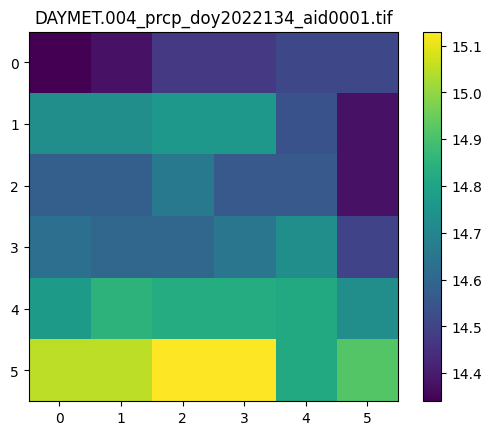

DAYMET.004_tmax_doy2022134_aid0001.tif


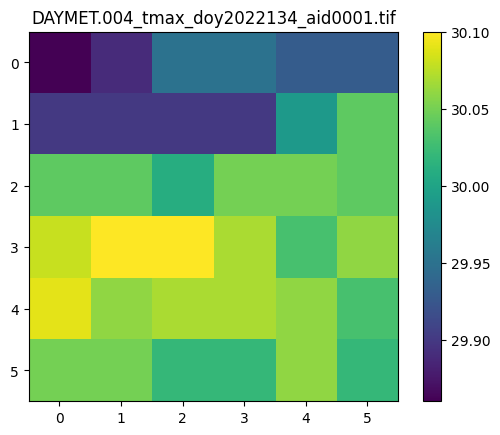

DAYMET.004_tmin_doy2022134_aid0001.tif


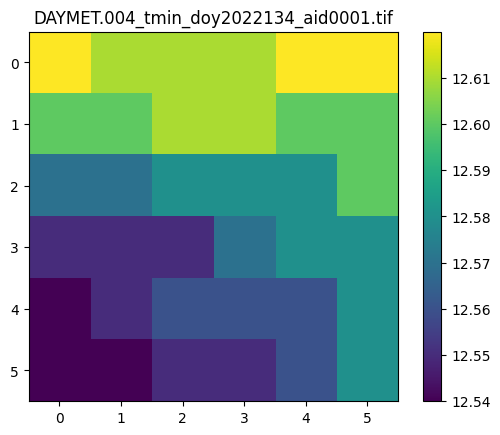

MOD13A1.061__500m_16_days_EVI_doy2022129_aid0001.tif


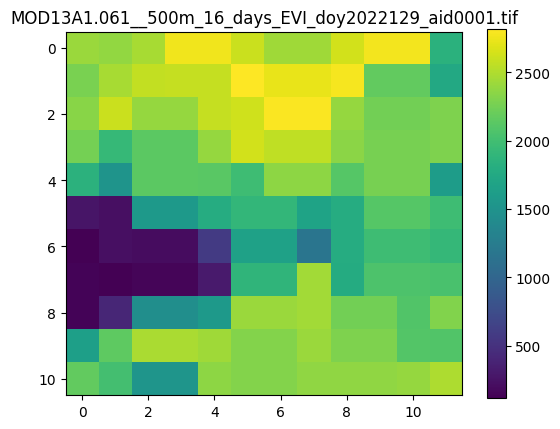

MOD13A1.061__500m_16_days_NDVI_doy2022129_aid0001.tif


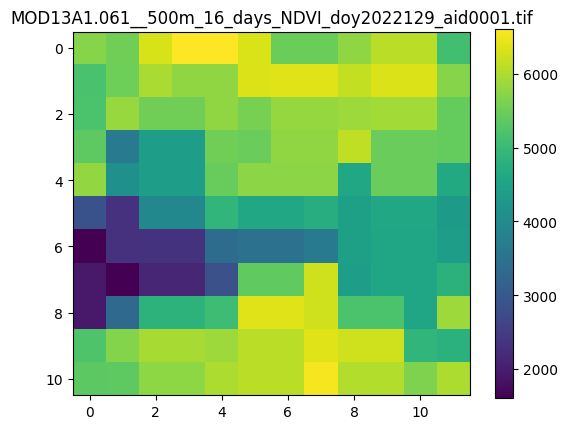

MOD15A2H.061_Lai_500m_doy2022129_aid0001.tif


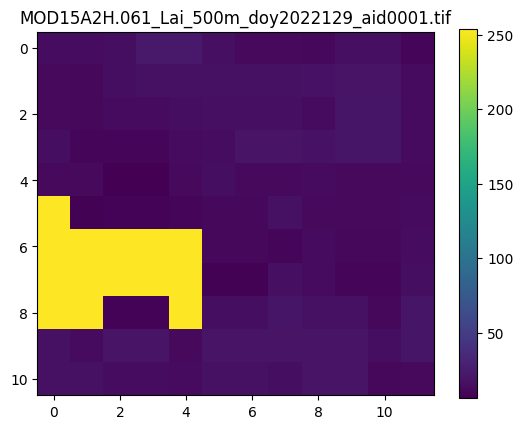

In [13]:
for filename in finalRelevantFiles:
    print(filename)
    dem = gdal.Open(destDir + "\\" + filename)
    demBand = dem.GetRasterBand(1) 
    demData = demBand.ReadAsArray().astype('float') 
    demFill = demBand.GetNoDataValue()
    demData[demData == demFill] = np.nan

    plt.imshow(demData)
    plt.title(filename)
    plt.colorbar()
    plt.show()

In [ ]:
for filename in finalRelevantFiles:
    print(filename)
    dem = gdal.Open(destDir + "\\" + filename)
    gt = ds.get